In [33]:
# Install necessary libraries (if not installed)
!pip install pandas numpy matplotlib seaborn missingno scikit-learn imbalanced-learn lightgbm xgboost catboost plotly

# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import warnings
warnings.filterwarnings("ignore")

# Visualization
import plotly.express as px

import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff


# Data Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline


In [34]:
#Load Dataset and Info
df = pd.read_csv('/Users/ferminayat/Desktop/Diabetes_Sets/diabetic_data.csv')

df.head()
df.info() 
df.describe()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [35]:
# Display only columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
print("Columns with missing values:\n", missing_values)

# Display only duplicate rows if they exist
duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
    print(f"\nTotal duplicate rows: {len(duplicate_rows)}")
    display(duplicate_rows)  # Show duplicate rows
else:
    print("\nNo duplicate rows found.")

Columns with missing values:
 max_glu_serum    96420
A1Cresult        84748
dtype: int64

No duplicate rows found.


In [36]:
# Load the IDS mapping dataset
ids_mapping = pd.read_csv('/Users/ferminayat/Desktop/Diabetes_Sets/IDS_mapping.csv')

print("\nIDS Mapping Data:")
print(ids_mapping.head())

# Check for missing values in IDS_mapping
print("\nMissing values in IDS_mapping:")
print(ids_mapping.isnull().sum())

# Check for duplicates in IDS_mapping
print("\nDuplicate rows in IDS_mapping:")
print(ids_mapping[ids_mapping.duplicated()])


IDS Mapping Data:
  admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available

Missing values in IDS_mapping:
admission_type_id    2
description          5
dtype: int64

Duplicate rows in IDS_mapping:
   admission_type_id description
40               NaN         NaN


In [37]:
print(ids_mapping.columns)  # List all column names


Index(['admission_type_id', 'description'], dtype='object')


In [38]:
diabetic_data = df.copy()


# Replace '?' with NaN
diabetic_data.replace('?', np.nan, inplace=True)

# Convert 'readmitted' to numeric values
diabetic_data['readmitted'] = diabetic_data['readmitted'].replace({'NO': 0, '<30': 1, '>30': 2}).astype(int)

# Convert admission_type_id to numeric
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce')
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce')

# Remove duplicate patients, keeping the first occurrence
diabetic_data.drop_duplicates(subset=['patient_nbr'], keep='first', inplace=True)

# Drop rows with missing 'Description' in IDS mapping
ids_mapping.dropna(subset=['description'], inplace=True)

# Convert admission_type_id to string for merging
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype(str)

# Save cleaned data
diabetic_data.to_csv("cleaned_diabetic_data.csv", index=False)
ids_mapping.to_csv("cleaned_IDS_mapping.csv", index=False)

# Display cleaned data previews
print("Cleaned Diabetic Data:")
display(diabetic_data.head())

print("\nCleaned IDS Mapping Data:")
display(ids_mapping.head())


Cleaned Diabetic Data:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,2
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0



Cleaned IDS Mapping Data:


,admission_type_id,description
0,1.0,Emergency
1,2.0,Urgent
2,3.0,Elective
3,4.0,Newborn
4,5.0,Not Available


In [39]:


df.to_csv("/Users/ferminayat/Desktop/Diabetes_Sets/cleaned_diabetic_data.csv", index=False)


print("Cleaned diabetic dataset saved in Diabetes_Sets folder!")



Cleaned diabetic dataset saved in Diabetes_Sets folder!


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("cleaned_diabetic_data.csv")

# Quick check
print(df.head())


   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

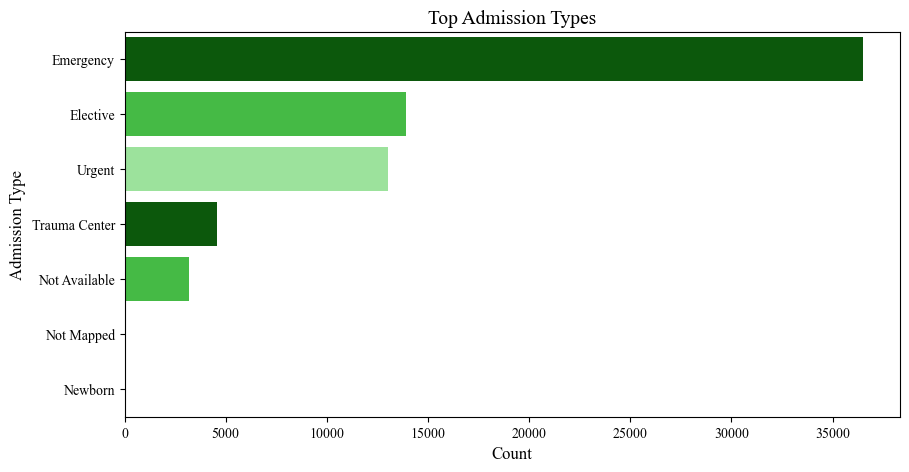

In [41]:
# Create a mapping dictionary
admission_mapping = {
    1: "Emergency",
    2: "Urgent",
    3: "Elective",
    4: "Newborn",
    5: "Not Available",
    6: "Trauma Center",
    7: "Not Mapped"
}

# Apply the mapping to your DataFrame
df["admission_type"] = df["admission_type_id"].map(admission_mapping)

# Plot with updated labels
plt.figure(figsize=(10,5))
plt.rcParams["font.family"] = "Times New Roman"

sns.countplot(y=df['admission_type'], order=df['admission_type'].value_counts().index, 
              palette=["#006400", "#32CD32", "#90EE90"])
plt.title("Top Admission Types", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Admission Type", fontsize=12)

plt.show()


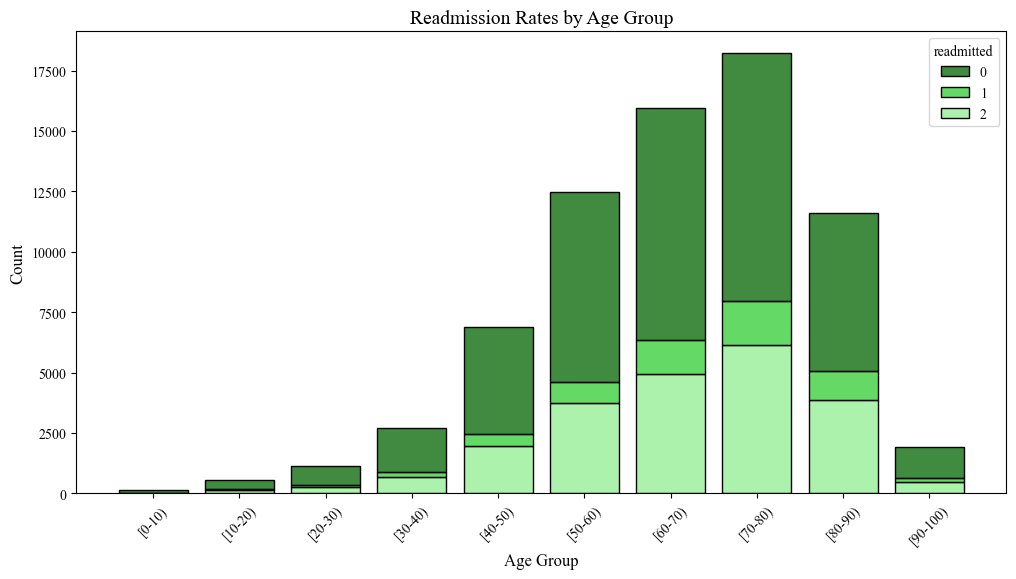

In [42]:
plt.figure(figsize=(12,6))
plt.rcParams["font.family"] = "Times New Roman"

sns.histplot(data=df, x="age", hue="readmitted", multiple="stack", 
             palette=["#006400", "#32CD32", "#90EE90"], shrink=0.8)
plt.title("Readmission Rates by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)

plt.show()


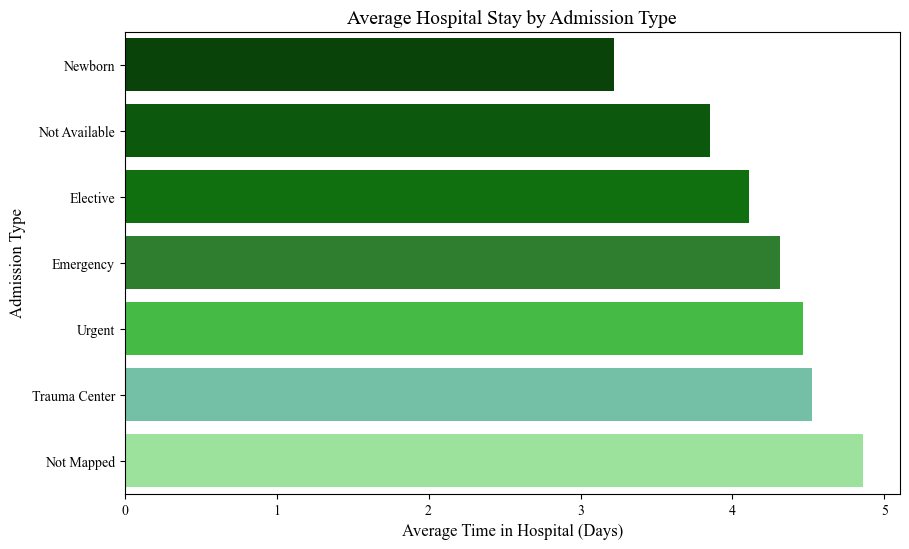

In [43]:
plt.figure(figsize=(10,6))
plt.rcParams["font.family"] = "Times New Roman"

green_palette = ["#004d00", "#006400", "#008000", "#228B22", "#32CD32", "#66CDAA", "#90EE90"]

# Create the bar plot
sns.barplot(
    x=df.groupby('admission_type')['time_in_hospital'].mean().sort_values(),
    y=df.groupby('admission_type')['time_in_hospital'].mean().sort_values().index,
    palette=green_palette
)

# Titles and labels
plt.title("Average Hospital Stay by Admission Type", fontsize=14)
plt.xlabel("Average Time in Hospital (Days)", fontsize=12)
plt.ylabel("Admission Type", fontsize=12)

plt.show()
